# 배달 시간 예측 과제 풀이

## Summary
배달 데이터를 바탕으로 (위치, 메뉴, 평가지표 등) 배달 시간을 예측하는 문제를 해결하고자 한다.
이를 위해, 데이터를 표준화 및 전처리 하였으며, 특히 메뉴(Cuisines) 관련 해서는 대표적인 메뉴군들에 대해서 해당되는 품목이 있는지 라벨링을 실시하였다.
이를 바탕으로, 선형회귀 분석을 실시한 결과 평균값으로는 약 8분정도의 오차, 늦은 배달에 2배의 페널티를 부여한 기준으로는 9분 정도의 오차를 보였다.

또한, Delivery_Time이 7개 정도의 값으로 퍼져 있어 대표적인 분류 모델인 트리 모델 및 이를 보안한 랜덤포레스트와의 결과를 비교해 보았다.
추가로, 선형 모델 개선을 위해 PCA 및, 변수선택의 한 방법이 될 수 있는 Lasso 회귀를 통해 주성분을 추출하여 분석 및 비교하였다.

## Data Set등 기본 준비

In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('C:/Users/HP/Desktop/datapractice/predict_delivery_time.csv')

In [3]:
data.head(5)

,Restaurant,Location,Cuisines,AverageCost,MinimumOrder,Rating,Votes,Reviews,DeliveryTime
0,ID6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",200,50,3.5,12.0,4.0,30
1,ID2882,"Sector 3, Marathalli","Ice Cream, Desserts",100,50,3.5,11.0,4.0,30
2,ID1595,Mumbai Central,"Italian, Street Food, Fast Food",150,50,3.6,99.0,30.0,65
3,ID5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",250,99,3.7,176.0,95.0,30
4,ID6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",200,99,3.2,521.0,235.0,65


## 데이터 변수에 대한 설명
- Restaurant : 레스토랑의 아이디가 주어진다.
- Location : 레스토랑이 어디있는지 표현
- Cuisines : 어떤 음식을 파는가?
- Averagecost : 음식구매 1인당 평균 비용
- MinumumOrder : 최소 주문량
- Rating : 레스토랑의 평점
- Votes : 받은 총 평점의 개수
- Review : 리뷰의 개수
- DeliveryTime : 배달 시간 (Target Class)

## EDA 및 결측치처리

In [4]:
# 결측치 확인
data.isna().sum()

Restaurant         0
Location           0
Cuisines           0
AverageCost        0
MinimumOrder       0
Rating          1191
Votes           2074
Reviews         2312
DeliveryTime       0
dtype: int64

In [5]:
print(len(data))

11094


전체 11000여개의 데이터 중 결측치는 다음과 같이 존재한다.

In [6]:
data['Rating'].unique()

array(['3.5', '3.6', '3.7', '3.2', '3.8', '4.0', '3.9', '4.2', nan, '2.8',
       '3.0', '3.3', '3.1', '4.7', '3.4', '4.1', 'NEW', '2.9', '4.6',
       '4.3', '2.6', '4.5', '4.4', '4.8', '2.4', '2.7', '2.5',
       'Opening Soon', '2.2', '4.9', '2.3', '2.1', 'Temporarily Closed'],
      dtype=object)

New, nan, Opening Soon, Temporaily Closed 등 다양한 결측치가 많다.
여기서 closed, Opening Soon 등은 의미가 없는 데이터다. 또한 Rating과 상관없이 Vote나 Review가 없는 식당도 추가적인 정보의 확인이 어려우므로 (평점이 낮을수록 배달시간이 느리다고 추측이 가능한데 아예 투표가 부족해서 데이터가 없으면 곤란하다.) 모든 na값을 drop한다.

In [7]:
data.dropna(axis = 0, how = 'any', inplace = True)
print(data.isna().sum())

Restaurant      0
Location        0
Cuisines        0
AverageCost     0
MinimumOrder    0
Rating          0
Votes           0
Reviews         0
DeliveryTime    0
dtype: int64


In [8]:
data['Rating'].unique()

array(['3.5', '3.6', '3.7', '3.2', '3.8', '4.0', '3.9', '4.2', '2.8',
       '3.0', '3.3', '3.1', '4.7', '3.4', '4.1', '2.9', '4.6', '4.3',
       '2.6', '4.5', '4.4', '4.8', '2.4', '2.7', '2.5', '2.2', '4.9',
       '2.3', '2.1'], dtype=object)

In [9]:
data.dtypes

Restaurant       object
Location         object
Cuisines         object
AverageCost      object
MinimumOrder      int64
Rating           object
Votes           float64
Reviews         float64
DeliveryTime      int64
dtype: object

In [10]:
data['AverageCost'].unique()

array(['200', '100', '150', '250', '650', '350', '800', '50', '400',
       '600', '300', '750', '450', '550', '1,000', '500', '900', '1,200',
       '950', '850', '700', '1,150', '1,100', '1,400', '2,050'],
      dtype=object)

이에 대해서도 다양한 형태의 값을 가지고 있는데, 값의 형태로 바꿔줘야 한다.

In [11]:
data['AverageCost'] = data['AverageCost'].apply(lambda s : int(s.replace(",","")) if "," in s else int(s))

In [12]:
data['AverageCost'].unique()

array([ 200,  100,  150,  250,  650,  350,  800,   50,  400,  600,  300,
        750,  450,  550, 1000,  500,  900, 1200,  950,  850,  700, 1150,
       1100, 1400, 2050], dtype=int64)

Rating이 Object일 수는 없다. float64형으로 변경 후 상관관계를 확인

In [13]:
data = data.astype({'Rating':'float'})
data.corr()

,AverageCost,MinimumOrder,Rating,Votes,Reviews,DeliveryTime
AverageCost,1.000000,0.110152,0.358936,0.451664,0.469711,0.142956
MinimumOrder,0.110152,1.000000,0.059025,0.121531,0.121289,0.245323
Rating,0.358936,0.059025,1.000000,0.448829,0.437079,0.117819
Votes,0.451664,0.121531,0.448829,1.000000,0.964191,0.194151
Reviews,0.469711,0.121289,0.437079,0.964191,1.000000,0.170745
DeliveryTime,0.142956,0.245323,0.117819,0.194151,0.170745,1.000000


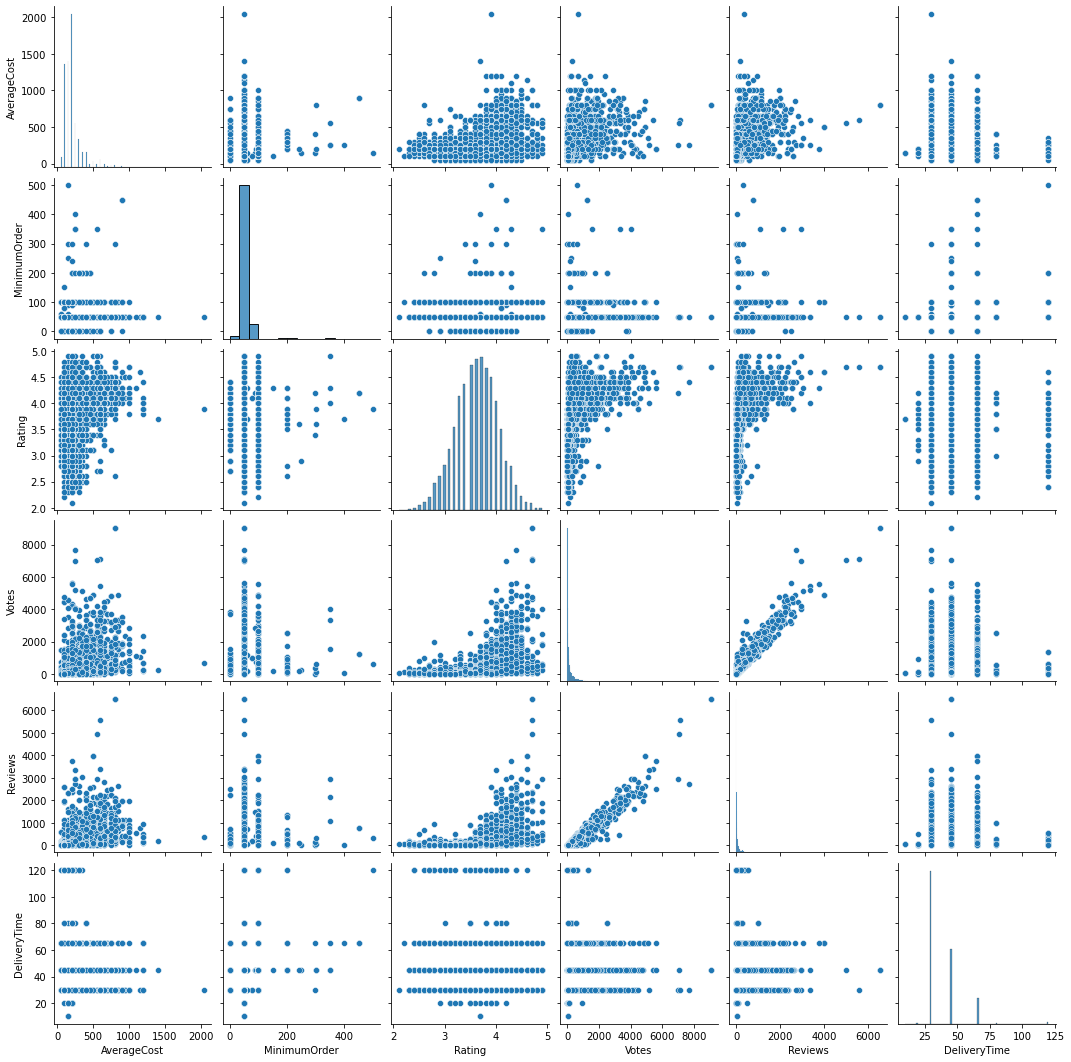

In [14]:
import seaborn as sns
sns.pairplot(data)

Rating은 정규분포 형태를 띄고 있고, Vote나 Reviews에 대해서는 왼쪽 값이 크고, 롱테일이 존재하는 형태이다. 즉 일부 식당에 대해서만 많은 평가나 리뷰를 받았다는 것을 의미한다. 또한 Minimum order는 특정 값에 몰려있는 것으로 보인다.

In [15]:
data['MinimumOrder'].unique()

array([ 50,  99,   0, 200, 450, 350,  79, 400, 199, 500, 250, 150,  90,
       299, 300, 240,  89,  59], dtype=int64)

그러나, 실제 값으로는 데이터 값이 다양하므로, 이에 대해서 전처리를 해야 한다.

In [16]:
data.corr()

,AverageCost,MinimumOrder,Rating,Votes,Reviews,DeliveryTime
AverageCost,1.000000,0.110152,0.358936,0.451664,0.469711,0.142956
MinimumOrder,0.110152,1.000000,0.059025,0.121531,0.121289,0.245323
Rating,0.358936,0.059025,1.000000,0.448829,0.437079,0.117819
Votes,0.451664,0.121531,0.448829,1.000000,0.964191,0.194151
Reviews,0.469711,0.121289,0.437079,0.964191,1.000000,0.170745
DeliveryTime,0.142956,0.245323,0.117819,0.194151,0.170745,1.000000


범주형 변수들에 대해서도 값들을 분석해본다.

In [17]:
data['Location'].unique()

array(['FTI College, Law College Road, Pune', 'Sector 3, Marathalli',
       'Mumbai Central', 'Sector 1, Noida',
       'Rmz Centennial, I Gate, Whitefield', 'Delhi UniversityGTB Nagar',
       'Yerawada, Pune, Maharashtra',
       'Delhi Administration Flats, Timarpur', 'Moulali, Kolkata',
       'Dockyard Road, Mumbai CST Area',
       'Gora Bazar, Rajbari, North Dumdum, Kolkata',
       'DBlock, Sector 63, Noida', 'Sector 14, Noida',
       'Laxman Vihar Industrial Area, Sector 3A, Gurgoan',
       'Pune University', 'Tiretti, Kolkata',
       'Sandhurst Road, Mumbai CST Area', 'MG Road, Pune',
       'Hyderabad Public School, Begumpet', 'Majestic',
       'Chandni Chowk, Kolkata',
       'Mico Layout, Stage 2, BTM Layout,Bangalore',
       'Delhi High Court, India Gate',
       'Chatta Bazaar, Malakpet, Hyderabad', 'Delhi Cantt.',
       'Babarpur, New Delhi, Delhi', 'Nathan Road, Mangaldas Road, Pune',
       'Panjetan Colony, Malakpet, Hyderabad', 'Sector 63A,Gurgaon',
       'R

이를 잘 보면 같은 Location 이름이 중복해서 들어가 있는 경우도 있다. 이는 분점으로 해석할 수 있는데 데이터상에서는 본점, 분점을 고려하지 않고 단순히 예측 시간이 주어져 있다. 이 또한 전처리가 필요할 것이다.

In [18]:
data['Cuisines'].unique()

array(['Fast Food, Rolls, Burger, Salad, Wraps', 'Ice Cream, Desserts',
       'Italian, Street Food, Fast Food', ...,
       'North Indian, Mughlai, Kebab, Chinese',
       'Chinese, Seafood, Asian, North Indian',
       'Tibetan, Chinese, Continental, Momos'], dtype=object)

배달 시간의 예측에서 가장 중요한 점은, 음식의 종류일 것이다. 문제는 현재 데이터 상황으로는, 특정 가게에서 팔고 있는 종류를 대표할 수 없을 뿐더러, 음식 종류가 다양한데, 어떤 대표군으로 묶어 주는 것이 합리적일 것이다. 이를 위해서는 종류의 수를 세야 할 것이다.
대표적인 메뉴/군에 대해서(다수결이거나, 대표적인 것이 있을 경우) 0-1로 binary 변수를 주고, 하나도 해당하지 않을 경우 나머지에 대해서는 ETC로 묶어서 정의해주자.

In [19]:
data['Cuisines']

0        Fast Food, Rolls, Burger, Salad, Wraps
1                           Ice Cream, Desserts
2               Italian, Street Food, Fast Food
3                Mughlai, North Indian, Chinese
4                               Cafe, Beverages
                          ...                  
11088            North Indian, Chinese, Biryani
11089      Tibetan, Chinese, Continental, Momos
11090                                 Fast Food
11091       South Indian, Chinese, North Indian
11092                              North Indian
Name: Cuisines, Length: 8782, dtype: object

In [20]:
# 각 행별로 접근하여 리스트를 합쳐야 하는 상황, 그런데 이 경우 인덱스를 리셋해야만 한다.
data.reset_index(drop = True, inplace = True)
data

,Restaurant,Location,Cuisines,AverageCost,MinimumOrder,Rating,Votes,Reviews,DeliveryTime
0,ID6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",200,50,3.5,12.0,4.0,30
1,ID2882,"Sector 3, Marathalli","Ice Cream, Desserts",100,50,3.5,11.0,4.0,30
2,ID1595,Mumbai Central,"Italian, Street Food, Fast Food",150,50,3.6,99.0,30.0,65
3,ID5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",250,99,3.7,176.0,95.0,30
4,ID6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",200,99,3.2,521.0,235.0,65
...,...,...,...,...,...,...,...,...,...
8777,ID944,"Rmz Centennial, I Gate, Whitefield","North Indian, Chinese, Biryani",150,50,3.6,56.0,18.0,30
8778,ID8067,"BTM Layout 1, Electronic City","Tibetan, Chinese, Continental, Momos",250,50,4.2,326.0,189.0,30
8779,ID4620,"Sector 14, Noida",Fast Food,100,50,3.6,36.0,16.0,30
8780,ID3392,Majestic,"South Indian, Chinese, North Indian",100,50,3.5,45.0,18.0,30


In [21]:
# 문자열 형태로 주어져있다.
menu = ''
for i in range(8782):
    menu += data['Cuisines'][i]
    menu += ', '

In [22]:
# 쉼표로 구분된 메뉴를 메뉴 항목별로 리스트에 담는다. 그 후 개수를 세본다.
menu_list = list(menu.split(', '))

import collections
menu_counts = collections.Counter(menu_list)

가장 어려운 부분은, 다국적 음식을 다루는 음식점들이 있음에도 불구하고 어떤 국가 음식 종류인지에 따라서 시간을 다르게 잡지 않고 있다는 점이다. 또한 음식군마다 만드는 시간이 다름에도 불구하고, 이것을 구분하지 않고 있음이 어렵다. 모든 변수를 다 사용하기에는 총 101개의 메뉴 종류가 있고, 이 안에도 지역군이 겹치거나, 상위-하위 개념들이 들어가는 경우가 많다. 또한 전체 표본 대비 1% 도 안되는 비중이 적은 데이터들도 존재한다. 따라서, 여기에서는, 임의로 약 5%에 해당하는 400개 이상의 데이터가 존재하는 경우에 대해서 모두 모델을 만들어보고자 한다.

In [23]:
data['NorthIndian'] = data['Cuisines'].apply(lambda s : 1 if 'North Indian'in s else 0)
data['Chinese'] = data['Cuisines'].apply(lambda s : 1 if 'Chinese'in s else 0)
data['FastFood'] = data['Cuisines'].apply(lambda s : 1 if 'Fast Food'in s else 0)
data['Beverages'] = data['Cuisines'].apply(lambda s : 1 if 'Beverages'in s else 0)
data['Desserts'] = data['Cuisines'].apply(lambda s : 1 if 'Desserts'in s else 0)
data['SouthIndian'] = data['Cuisines'].apply(lambda s : 1 if 'South Indian'in s else 0)
data['Mughlai'] = data['Cuisines'].apply(lambda s : 1 if 'Mughlai'in s else 0)
data['Biryani'] = data['Cuisines'].apply(lambda s : 1 if 'Biryani'in s else 0)
data['StreetFood'] = data['Cuisines'].apply(lambda s : 1 if 'Street Food'in s else 0)
data['Bakery'] = data['Cuisines'].apply(lambda s : 1 if 'Bakery'in s else 0)
data['Italian'] = data['Cuisines'].apply(lambda s : 1 if 'Italian'in s else 0)
data['Continental'] = data['Cuisines'].apply(lambda s : 1 if 'Continental'in s else 0)
data['Cafe'] = data['Cuisines'].apply(lambda s : 1 if 'Cafe'in s else 0)
data['Pizza'] = data['Cuisines'].apply(lambda s : 1 if 'Pizza'in s else 0)
data['Rolls'] = data['Cuisines'].apply(lambda s : 1 if 'Rolls'in s else 0)

In [24]:
# Location에 대해서도 동일한 처리를 한다.
loc = ''
for i in range(8782):
    loc += data['Location'][i]
    loc += ', '

loc_list = list(loc.split(', '))

loc_counts = collections.Counter(loc_list)

In [25]:
data['Noida'] = data['Location'].apply(lambda s : 1 if 'Noida' in s else 0)
data['Pune'] = data['Location'].apply(lambda s : 1 if 'Pune' in s else 0)
data['MicoLayout'] = data['Location'].apply(lambda s : 1 if 'MicoLayout' in s else 0)
data['Stage2'] = data['Location'].apply(lambda s : 1 if 'Stage2' in s else 0)
data['BTMLayoutBangalore'] = data['Location'].apply(lambda s : 1 if 'BTM Layout,Bangalore' in s else 0)
data['DBlock'] = data['Location'].apply(lambda s : 1 if 'DBlock' in s else 0)
data['Sector63'] = data['Location'].apply(lambda s : 1 if 'Sector 63' in s else 0)
data['Sector1'] = data['Location'].apply(lambda s : 1 if 'Sector 1' in s else 0)
data['MumbaiCSTArea'] = data['Location'].apply(lambda s : 1 if 'Mumbai CST Area' in s else 0)
data['FTICollege'] = data['Location'].apply(lambda s : 1 if 'FTI College' in s else 0)
data['LawCollegeRoad'] = data['Location'].apply(lambda s : 1 if 'Law College Road' in s else 0)
data['Kolkata'] = data['Location'].apply(lambda s : 1 if 'Kolkata' in s else 0)
data['DelhiUniversityGTBNagar'] = data['Location'].apply(lambda s : 1 if 'Delhi UniversityGTB Nagar' in s else 0)
data['Sector14'] = data['Location'].apply(lambda s : 1 if 'Sector 14' in s else 0)

In [26]:
data

,Restaurant,Location,Cuisines,AverageCost,MinimumOrder,Rating,Votes,Reviews,DeliveryTime,NorthIndian,...,BTMLayoutBangalore,DBlock,Sector63,Sector1,MumbaiCSTArea,FTICollege,LawCollegeRoad,Kolkata,DelhiUniversityGTBNagar,Sector14
0,ID6321,"FTI College, Law College Road, Pune","Fast Food, Rolls, Burger, Salad, Wraps",200,50,3.5,12.0,4.0,30,0,...,0,0,0,0,0,1,1,0,0,0
1,ID2882,"Sector 3, Marathalli","Ice Cream, Desserts",100,50,3.5,11.0,4.0,30,0,...,0,0,0,0,0,0,0,0,0,0
2,ID1595,Mumbai Central,"Italian, Street Food, Fast Food",150,50,3.6,99.0,30.0,65,0,...,0,0,0,0,0,0,0,0,0,0
3,ID5929,"Sector 1, Noida","Mughlai, North Indian, Chinese",250,99,3.7,176.0,95.0,30,1,...,0,0,0,1,0,0,0,0,0,0
4,ID6123,"Rmz Centennial, I Gate, Whitefield","Cafe, Beverages",200,99,3.2,521.0,235.0,65,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8777,ID944,"Rmz Centennial, I Gate, Whitefield","North Indian, Chinese, Biryani",150,50,3.6,56.0,18.0,30,1,...,0,0,0,0,0,0,0,0,0,0
8778,ID8067,"BTM Layout 1, Electronic City","Tibetan, Chinese, Continental, Momos",250,50,4.2,326.0,189.0,30,0,...,0,0,0,0,0,0,0,0,0,0
8779,ID4620,"Sector 14, Noida",Fast Food,100,50,3.6,36.0,16.0,30,0,...,0,0,0,1,0,0,0,0,0,1
8780,ID3392,Majestic,"South Indian, Chinese, North Indian",100,50,3.5,45.0,18.0,30,1,...,0,0,0,0,0,0,0,0,0,0


## Train-Test Set 분리

이를 위해서는 X, y 변수부터 분리를 하자.

In [27]:
X = data[['AverageCost', 'MinimumOrder', 'Rating', 'Votes', 'Reviews', 
          'NorthIndian', 'Chinese', 'FastFood', 'Beverages', 'Desserts', 
          'SouthIndian', 'Mughlai', 'Biryani', 'StreetFood', 'Bakery',
          'Italian', 'Continental', 'Cafe', 'Pizza', 'Rolls', 
          'Noida', 'Pune', 'MicoLayout', 'Stage2', 'BTMLayoutBangalore', 
          'DBlock', 'Sector63', 'Sector1', 'MumbaiCSTArea', 'FTICollege', 
          'LawCollegeRoad', 'Kolkata', 'DelhiUniversityGTBNagar', 'Sector14']]
y = data[['DeliveryTime']]

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

## 모델 결정 및 추가전처리 검토

풀어야 할 문제는 배달 시간을 예측하는 것이다. 배달 시간의 경우는 범주형 변수 상태가 아니다. 주어진 변수들을 바탕으로 최종 배달 시간을 예측해야 하는 문제이므로 회귀 문제를 풀어야 한다. 

모델은, 일반적인 선형회귀를 사용하려 한다. 그런데, 이를 위해서는 Rating, Vote, Review, Mincost에 대해서는 Scalering을 해줘야 한다.
나머지는 0, 1이므로 무관하다. 또 하나의 문제는, cost function이 일반적인 MSE가 아니라, 다른 기준에 둬야 한다는 것이다.

<AxesSubplot:xlabel='AverageCost', ylabel='Count'>

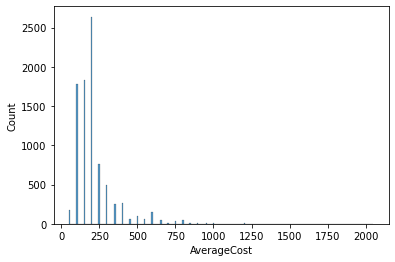

In [29]:
sns.histplot(x = "AverageCost", data =X)

<AxesSubplot:xlabel='MinimumOrder', ylabel='Count'>

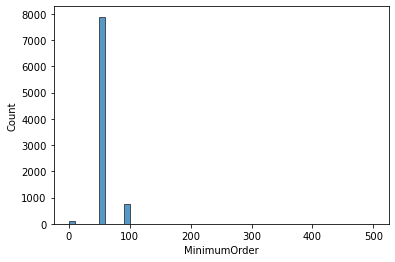

In [30]:
sns.histplot(x = "MinimumOrder", data =X, bins = 50)

<AxesSubplot:xlabel='Rating', ylabel='Count'>

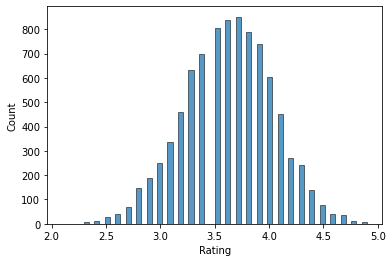

In [31]:
sns.histplot(x = "Rating", data =X)

<AxesSubplot:xlabel='Votes', ylabel='Count'>

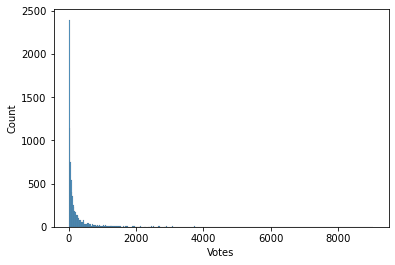

In [32]:
sns.histplot(x = "Votes", data =X)

<AxesSubplot:xlabel='Reviews', ylabel='Count'>

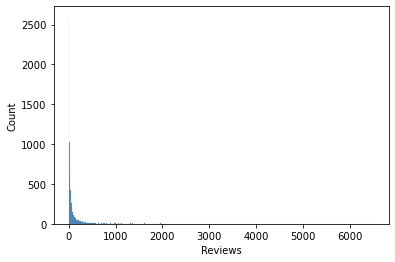

In [33]:
sns.histplot(x = "Reviews", data =X)

Vote, Review, Averagecost, MinimumOrder 는 log를 먼저 취한 후, Rating, Vote, Review, Mincost 4개의 변수에 대해 StandardScaler를 적용하려고 한다.


In [34]:
import numpy as np

X_train['Votes'] = X_train['Votes'].apply(lambda x: np.log(x+1e-6))
X_test['Votes'] = X_test['Votes'].apply(lambda x: np.log(x+1e-6))
X_train['Reviews'] = X_train['Reviews'].apply(lambda x: np.log(x+1e-6))
X_test['Reviews'] = X_test['Reviews'].apply(lambda x: np.log(x+1e-6))
X_train['AverageCost'] = X_train['AverageCost'].apply(lambda x: np.log(x+1e-6))
X_test['AverageCost'] = X_test['AverageCost'].apply(lambda x: np.log(x+1e-6))
X_train['MinimumOrder'] = X_train['MinimumOrder'].apply(lambda x: np.log(x+1e-6))
X_test['MinimumOrder'] = X_test['MinimumOrder'].apply(lambda x: np.log(x+1e-6))

<ipython-input-34-c0542ff0d4cf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Votes'] = X_train['Votes'].apply(lambda x: np.log(x+1e-6))
<ipython-input-34-c0542ff0d4cf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Votes'] = X_test['Votes'].apply(lambda x: np.log(x+1e-6))
<ipython-input-34-c0542ff0d4cf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train[['AverageCost', 'MinimumOrder', 'Rating', 'Votes', 'Reviews']])
X_train_scale = scaler.transform(X_train[['AverageCost', 'MinimumOrder', 'Rating', 'Votes', 'Reviews']])
X_test_scale = scaler.transform(X_test[['AverageCost', 'MinimumOrder', 'Rating', 'Votes', 'Reviews']])

In [36]:
X_train_scale

array([[ 0.57640041,  0.07715532,  0.66255834, -0.42268811, -0.05413971],
       [-0.40840073,  0.07715532, -1.28385224, -1.83192444, -1.25896552],
       [ 0.14621051,  0.07715532, -0.31064695, -0.51465683, -0.77749412],
       ...,
       [-1.19008137,  0.07715532,  0.66255834, -0.35765959,  0.01025858],
       [ 1.48250239,  0.07715532, -2.0137562 , -0.8123909 , -1.88324443],
       [ 2.09643714,  0.07715532,  2.36566759,  1.19151067,  1.34641227]])

In [37]:
X_train[['AverageCost', 'MinimumOrder', 'Rating', 'Votes', 'Reviews']] = X_train_scale
X_test[['AverageCost', 'MinimumOrder', 'Rating', 'Votes', 'Reviews']] = X_test_scale

<ipython-input-37-262b22cc36dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['AverageCost', 'MinimumOrder', 'Rating', 'Votes', 'Reviews']] = X_train_scale
C:\Users\HP\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-37-262b22cc36dd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [38]:
X_train

,AverageCost,MinimumOrder,Rating,Votes,Reviews,NorthIndian,Chinese,FastFood,Beverages,Desserts,...,BTMLayoutBangalore,DBlock,Sector63,Sector1,MumbaiCSTArea,FTICollege,LawCollegeRoad,Kolkata,DelhiUniversityGTBNagar,Sector14
3352,0.576400,0.077155,0.662558,-0.422688,-0.054140,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
4122,-0.408401,0.077155,-1.283852,-1.831924,-1.258966,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
893,0.146211,0.077155,-0.310647,-0.514657,-0.777494,1,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
6701,0.576400,0.077155,1.635764,1.062752,1.206908,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1850,0.146211,0.077155,-0.067346,0.550690,0.471064,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0.146211,0.425576,1.149161,0.387796,0.613872,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5191,-1.190081,0.077155,0.419257,-0.105980,-0.520657,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
5390,-1.190081,0.077155,0.662558,-0.357660,0.010259,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
860,1.482502,0.077155,-2.013756,-0.812391,-1.883244,1,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


값들의 표준화가 완료되었다. 이제 모델의 적용을 마무리하자.

## Cost Function의 계산 및 선형회귀분석의 실시

In [39]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [40]:
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred))

0.19144820702861642


In [41]:
## MAE 계산
from sklearn.metrics import mean_absolute_error
mse = mean_absolute_error(y_test, y_pred)
print(mse)

8.202236108262378


어라? 실질적으로 평균 오차는 8분 정도밖에 나지 않는다. R^2 값이 모든 것을 말하지는 않는다.
적당한 오차 기준을 삼는 것이 중요함을 알 수 있다.

이제 늦은 배달 경험을 평가하는 지표인 Weight_MAE를 식으로 쓰면 다음과 같다.
$$WMAE = \frac{1}{\sum w_{i}} \sum_{i}{w_{i}|y_{i}-\hat{y}_{i}|}$$

In [42]:
import numpy as np
# 각각을 리스트로 변경
y_test_list = list(y_test['DeliveryTime'].values)
y_pred_list = list(y_pred.flatten())

In [43]:
def weight_delivery(real, pred):
    weight = 0
    error = 0
    for i in range(len(real)):
        if real[i] > pred[i]:
            weight += 2
            error += 2 * (real[i] - pred[i])
        elif real[i] < pred[i]:
            weight += 1
            error += (pred[i] - real[i])
        elif real[i] == pred[i]:
            weight += 1
    return error / weight

In [44]:
weight_delivery(y_test_list, y_pred_list)

8.95643303022668

Penalty를 변경한 결과 약 9분 남짓한 정도의 오차를 가지고 있다.
마지막으로, Under-prediction의 비율을 계산하고자 한다. 여기서 Under-prediction의 경우, 실제 배달시간이 더 걸린 경우를 의미한다.

In [45]:
def under_prediction_ratio(real, pred):
    count = 0
    for i in range(len(real)):
        if real[i] > pred[i]:
            count += 1
    return count / len(real)

In [46]:
under_prediction_ratio(y_test_list, y_pred_list)

0.3829690346083789

## 분류모델 - Tree Model과의 비교

그렇다면, 분류 모델을 쓰면 어떻게 될까? 사실, 그냥 전체 데이터셋을 굳이 미리 봤다면 (그러면 안되지만), 배달 예측 시간은 7개 정도의 종류밖에 없다. 그러면 아예 이 7개중 1개로만 분류되게 하면 어떨까?

In [47]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(random_state = 0,
                                      max_depth = 10,
                                      criterion = 'gini')
decision_tree = decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

분류 자체가 잘 되었는지, 분류의 정확도를 확인해보자.

In [48]:
# 분류모델 일치도
np.mean(y_pred.flatten() == y_test['DeliveryTime'].values)

0.674408014571949

In [49]:
mse = mean_absolute_error(y_test, y_pred)
print(mse)

6.721311475409836


In [50]:
y_test_list = list(y_test['DeliveryTime'].values)
y_pred_list = list(y_pred.flatten())
print(weight_delivery(y_test_list, y_pred_list))

9.2652058934643


음? Tree로 할 경우, weight_delivery에서는 더 나쁜 결과를 보인다. under_prediction ratio를 확인하면 다음과 같다.

In [51]:
under_prediction_ratio(y_test_list, y_pred_list)

0.2053734061930783

## 분류모델 - Random Forest와의 비교

In [52]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators = 100, # 트리의 개수
                                max_depth = 10, # 각 트리당 최대 깊이
                                criterion='gini') # 분류지표
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

<ipython-input-52-fb1770062f7f>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, y_train)


In [53]:
# 분류 모델 일치도
np.mean(y_pred.flatten() == y_test['DeliveryTime'].values)

0.691712204007286

In [54]:
mse = mean_absolute_error(y_test, y_pred)
print(mse)

6.247723132969035


In [55]:
y_test_list = list(y_test['DeliveryTime'].values)
y_pred_list = list(y_pred.flatten())
print(weight_delivery(y_test_list, y_pred_list))

9.352219415373511


Random Forest로 했음에도 불구하고, 실제 결과엔 타격이 있어 보인다. underprediction ratio 및 지각 시간에 대한 출력을 보자.

In [56]:
under_prediction_ratio(y_test_list, y_pred_list)

0.26183970856102

이를 위해 Random Forest 기준으로, y_test가 더 큰, 즉 다시말해 예측시간보다 더 늦게 배달된 경우를 다 확인해보면 30분 이상 늦은 경우도 많이 보이며 심할 경우 90분 이상 늦은 최악의 경험을 가져다 준 경우가 보인다. 이러한 케이스가 많기 때문에 weight에서 더 취약함을 알 수 있다.

## PCA의 적용

이번에는 PCA를 적용할려고 한다.
최적 components값이 어디인지 시각적으로 확인해보고자 한다. 
사용할 error 함수는 앞에서 만든 Weight_delivery이다.

In [57]:
from sklearn.decomposition import PCA
train_error = []
pred_error = []
y_train_list = list(y_train['DeliveryTime'].values)
y_test_list = list(y_test['DeliveryTime'].values)


for i in range(1, 35):
    pca = PCA(n_components = i)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    reg = LinearRegression()
    reg.fit(X_train_pca, y_train)
    y_learned = reg.predict(X_train_pca)
    y_pred = reg.predict(X_test_pca)
    
    y_learned_list = list(y_learned.flatten())
    y_pred_list = list(y_pred.flatten())
    
    train_error.append(weight_delivery(y_train_list, y_learned_list))
    pred_error.append(weight_delivery(y_test_list, y_pred_list))

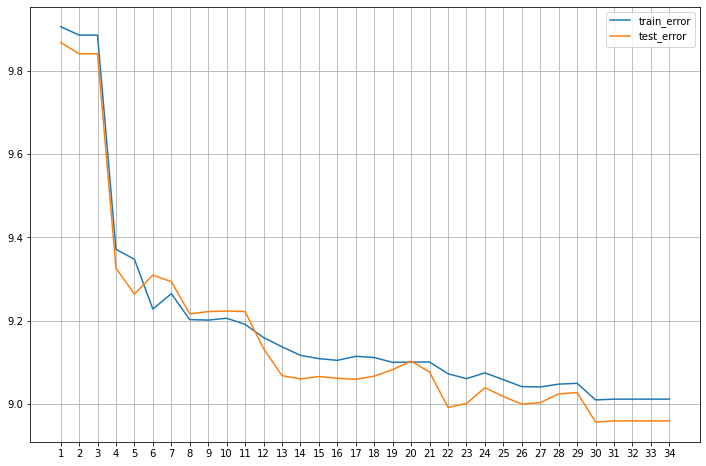

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
sns.lineplot(x = np.arange(1, 35), y = train_error, label = 'train_error')
sns.lineplot(x = np.arange(1, 35), y = pred_error, label = 'test_error')
plt.xticks(np.arange(1, 35))
plt.grid()
plt.show()

전체적으로 n 값이 증가할때마다 에러가 줄어드는 경향이 있다.
한편, n_compents가 4개가 될 때, error 개선의 효과가 가장 커기는 지점으로, 효율 측면에서는 n_components = 4 선택도 무방하다.
이 역시, 약 9분 정도의 오차를 가지고 있다.

# PCA n=4인 경우

In [59]:
pca = PCA(n_components = 4)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
    
reg = LinearRegression()
reg.fit(X_train_pca, y_train)
y_learned = reg.predict(X_train_pca)
y_pred = reg.predict(X_test_pca)
    
y_learned_list = list(y_learned.flatten())
y_pred_list = list(y_pred.flatten())

mse = mean_absolute_error(y_test, y_pred)
print(mse)
print(weight_delivery(y_test_list, y_pred_list))
print(under_prediction_ratio(y_test_list, y_pred_list))

8.463232713839753
9.326443391787533
0.37067395264116576


## Lasso 규제의 적용

Lasso 규제를 통해 실제로 유의미한 변수를 찾아볼 수 있다.

In [60]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 0.1)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

In [61]:
# mse 비교
mse = mean_absolute_error(y_test, y_pred)
print(mse)

8.234799930879674


In [62]:
y_test_list = list(y_test['DeliveryTime'].values)
y_pred_list = list(y_pred.flatten())
print(weight_delivery(y_test_list, y_pred_list))

9.112250614232856


In [63]:
lasso.coef_

array([ 0.11595696,  0.59704018, -2.68399301,  6.17573548,  0.04414174,
        0.        , -0.        , -0.17281413, -0.        ,  0.80889163,
       -0.93786349,  0.20298855,  0.        , -0.        ,  7.08203531,
        0.        , -0.        , -0.39627695,  0.        ,  0.        ,
        1.12462857, -1.43662057,  0.        ,  0.        , -0.        ,
       -0.        ,  0.33419811,  0.23352487, -0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        ])

$\alpha = 0.1$를 적용한 결과, 앞에서 결정한 20개의 변수 중 9 개 정도는 규제화 작업을 통해 0 값을 가지게 되었다. 다시 말해 11개의 변수만으로도 유사한 결과를 얻어낼 수 있음을 알 수 있다. Under_Prediction_Ratio 또한 비슷한 결과가 나옴을 확인할 수 있다.

In [64]:
under_prediction_ratio(y_test_list, y_pred_list)

0.3656648451730419

## SGD Regressor

In [65]:
from sklearn.linear_model import SGDRegressor
SGD = SGDRegressor(max_iter = 1000, tol=1e-3)
SGD.fit(X_train, y_train)
y_pred = SGD.predict(X_test)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [66]:
mse = mean_absolute_error(y_test, y_pred)
print(mse)

8.217946597009366


In [67]:
y_test_list = list(y_test['DeliveryTime'].values)
y_pred_list = list(y_pred.flatten())
print(weight_delivery(y_test_list, y_pred_list))

8.975187706455724


In [68]:
under_prediction_ratio(y_test_list, y_pred_list)

0.3820582877959927